In [40]:
options (warn = -1)
# library required packages in the current session.
library(tidyverse)
library(Seurat)
library(clusterProfiler)
library(org.Hs.eg.db)

In [41]:
# Take G12D as an example
protein.use <- "G12D"
gene.use <- "KRAS"
with.mutation <- c("1/1", "0/1")
without.mutation <- c("0/0")

# file path:
# {sample_name}_snp_variant_table.csv: /path/to/celescope snp output folder/09.analysis_snp/
# {sample_name}_snp_gt.csv: /path/to/celescope snp output folder/09.analysis_snp/
# {sample_name}_ZL_tsne_coord.tsv: /path/to/celescope rna output folder/06.analysis/

snp.info <- read_csv("./test_data/09.analysis_snp/focuscope_snp_variant_table.csv") %>% 
    dplyr::filter(!Protein %in% NA)

gt.df <- read_csv("./test_data/09.analysis_snp/focuscope_snp_gt.csv") %>% 
    dplyr::rename("chr_pos" = "X1")

tsne.df <- read_tsv("./test_data/rna/06.analysis/B1110-V7-2-R1V8-50_ZL_tsne_coord.tsv") %>% 
    dplyr::rename("barcode" = "X1")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Chrom = col_double(),
  Pos = col_double(),
  Alleles = col_character(),
  Gene = col_character(),
  `0/0` = col_double(),
  `0/1` = col_double(),
  `1/1` = col_double(),
  mRNA = col_character(),
  Protein = col_character()
)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  AACTCACCAGCAGGAAATCATTCC = col_logical(),
  AAGACGGAGAGCTGAAAAGGTACA = col_logical(),
  AATCCGTCCACTTCGATGGTGGTA = col_logical(),
  ACACAGAAAAGGTACATAGGATGA = col_logical(),
  ACTATGCATCTTCACAACAAGCTA = col_logical(),
  AGCAGGAAACGCTCGAAGCACCTC = col_logical(),
  AT

In [42]:
# how to get Seurat object
# 1. /path/to/celescope rna output folder/06.analysis/{sample_name}.rds or
# 2. use Seurat to analysis: /path/to/celescope rna output folder/05.count/ or 
# 3. covert h5ad to seurat object

# how to get celltype
# 1. use SingleR to analysis or
# 2. manual annotation

# load rds and celltype info
rds <- readRDS("test_data/rna/rds/rds_.diff_PRO.rds")
celltype  <- read_tsv("./test_data/rna/celltype.txt")
celltype$barcode <- str_c("rna_data", "_", celltype$barcode)
head(celltype,3)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  barcode = col_character(),
  celltype = col_character()
)



barcode,celltype
<chr>,<chr>
rna_data_AAACATCGAAACATCGCGCTGATC,type_C
rna_data_AAACATCGAACAACCAACCTCCAA,type_C
rna_data_AAACATCGAACCGAGATGGTGGTA,type_A


In [43]:
# Get the position info of G12D-KRAS
protein.pos.df <- snp.info %>% 
    dplyr::filter(str_detect(Protein, protein.use) & Gene %in% gene.use) %>% 
    dplyr::select(Chrom, Pos) 

protein.pos <- str_c(protein.pos.df$Chrom, "_", protein.pos.df$Pos)
protein.pos

[1] "12_25245350"

In [44]:
# Get the genetype info of G12D-KRAS in each cell
protein.gt.df <- gt.df %>% 
    dplyr::filter(str_detect(chr_pos, protein.pos)) %>% 
    gather(key = barcode, value = genetype, -chr_pos) %>% 
    dplyr::mutate(
        gene = gene.use, 
        protein = protein.use,
        is_SNV = case_when(
            genetype %in% with.mutation ~ str_glue("{protein.use}+"),
            genetype %in% without.mutation ~ str_glue("{protein.use}-"),
            genetype %in% c(NA) ~ "None"
        )
    )

head(protein.gt.df, 3)

chr_pos,barcode,genetype,gene,protein,is_SNV
<chr>,<chr>,<chr>,<chr>,<chr>,<glue>
12_25245350_252,AAACATCGAAACATCGCGCTGATC,0/0,KRAS,G12D,G12D-
12_25245350_252,AAACATCGAACAACCAACCTCCAA,0/0,KRAS,G12D,G12D-
12_25245350_252,AAACATCGAACCGAGATGGTGGTA,1/1,KRAS,G12D,G12D+


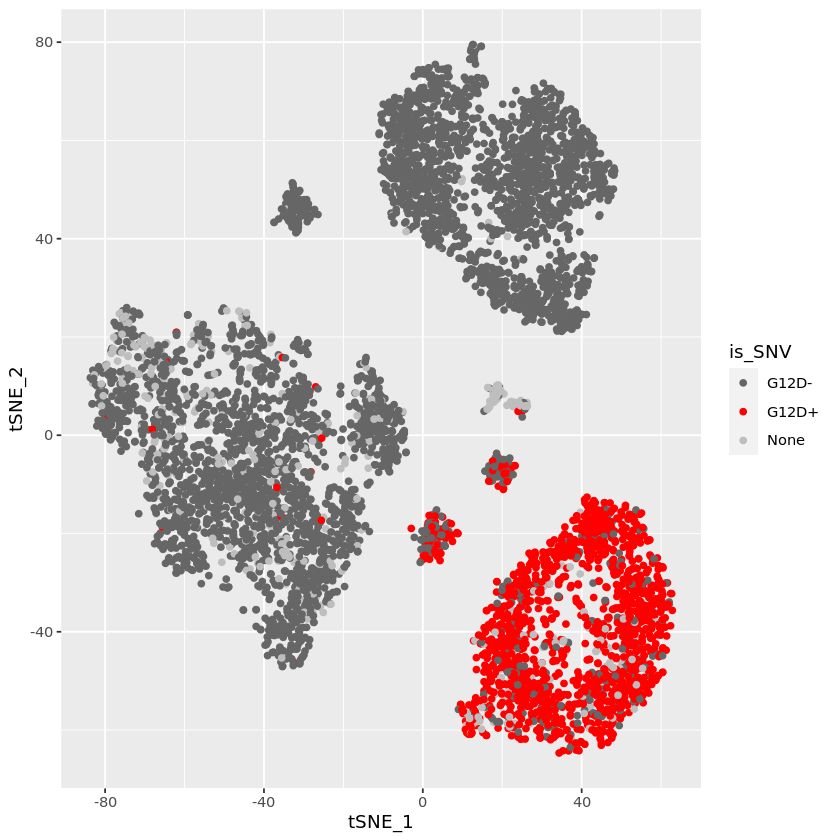

In [45]:
# plot SNV in tSNE 
tsne.df %>% 
    dplyr::left_join(protein.gt.df, by = "barcode") %>% 
    ggplot(aes(tSNE_1, tSNE_2, color = is_SNV)) + 
    geom_point() +
    scale_color_manual(values = c("gray40", "red", "gray"))

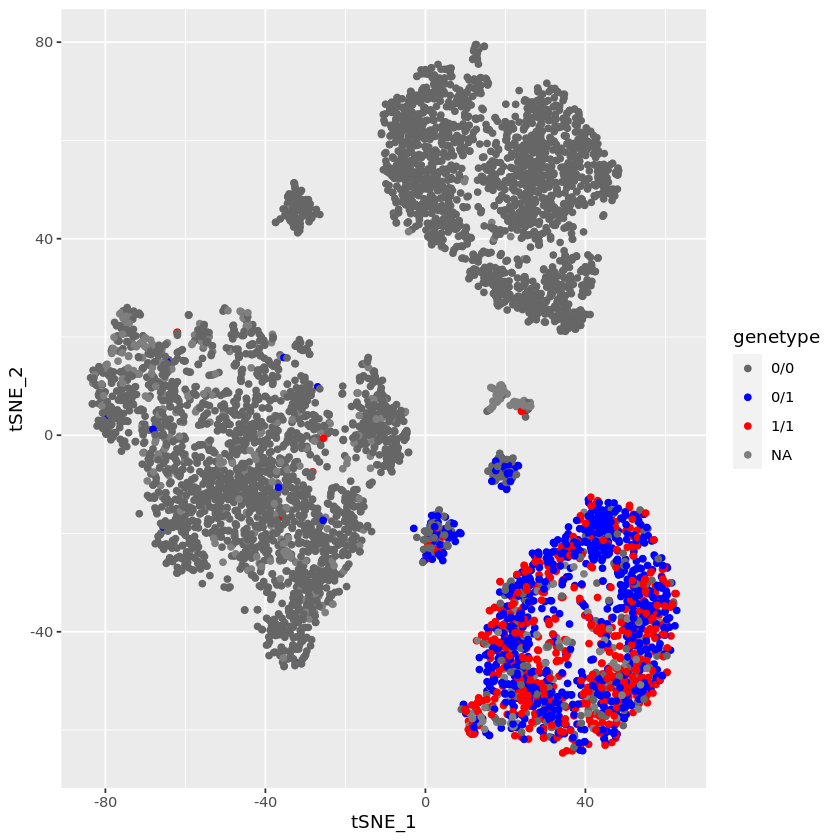

In [46]:
# plot gene type in tSNE
tsne.df %>% 
    left_join(protein.gt.df, by = "barcode") %>% 
    ggplot(aes(tSNE_1, tSNE_2, color = genetype)) + 
    geom_point() +
    scale_color_manual(values = c("gray40", "blue", "red", "gray"))

In [47]:
# add G12D genetype and celltype info to seurat object metadata
rds@meta.data[['barcode']] <- rownames(rds@meta.data)
protein.gt.df[['barcode']] <- str_c("rna_data", "_", protein.gt.df[['barcode']])
rds@meta.data <- rds@meta.data %>% 
    left_join(celltype, by = "barcode") %>% 
    left_join(protein.gt.df, by = "barcode")
rownames(rds@meta.data) <- rds@meta.data[['barcode']]
rds@meta.data[['barcode']] <- NULL
head(rds@meta.data, 3)

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,RNA_snn_res.0.8,seurat_clusters,celltype,chr_pos,genetype,gene,protein,is_SNV
,<fct>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<glue>
rna_data_AAACATCGAAACATCGCGCTGATC,rna_data,13270,3935,rna_data,11.017332,7,7,type_C,12_25245350_252,0/0,KRAS,G12D,G12D-
rna_data_AAACATCGAACAACCAACCTCCAA,rna_data,8980,3257,rna_data,9.265033,7,7,type_C,12_25245350_252,0/0,KRAS,G12D,G12D-
rna_data_AAACATCGAACCGAGATGGTGGTA,rna_data,4927,2132,rna_data,16.034098,4,4,type_A,12_25245350_252,1/1,KRAS,G12D,G12D+


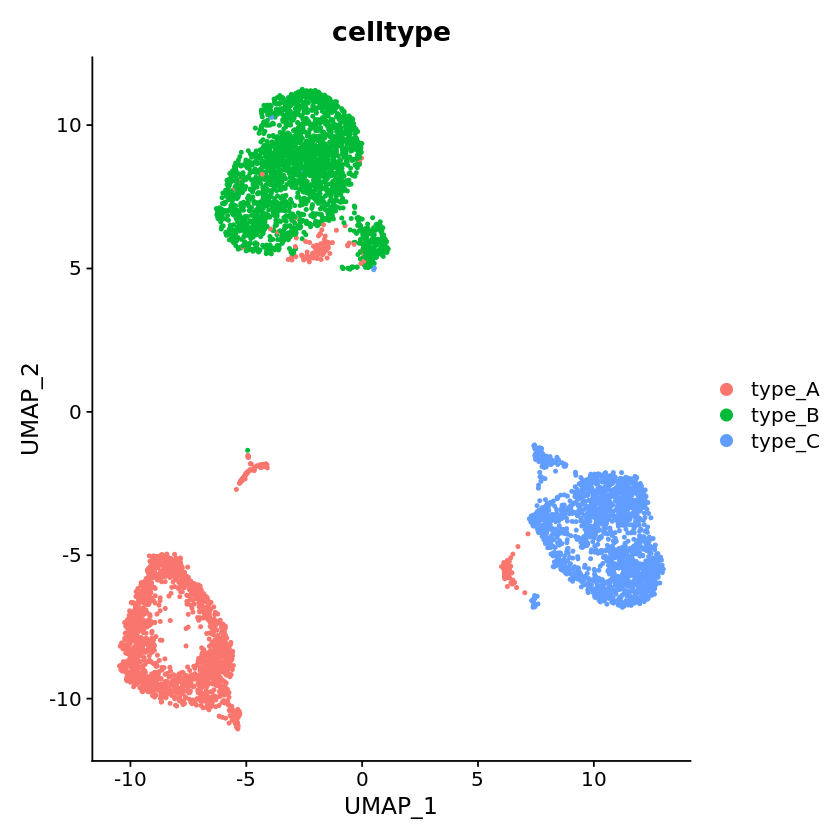

In [48]:
DimPlot(rds, reduction = "umap",group.by = "celltype",pt.size = 0.75)

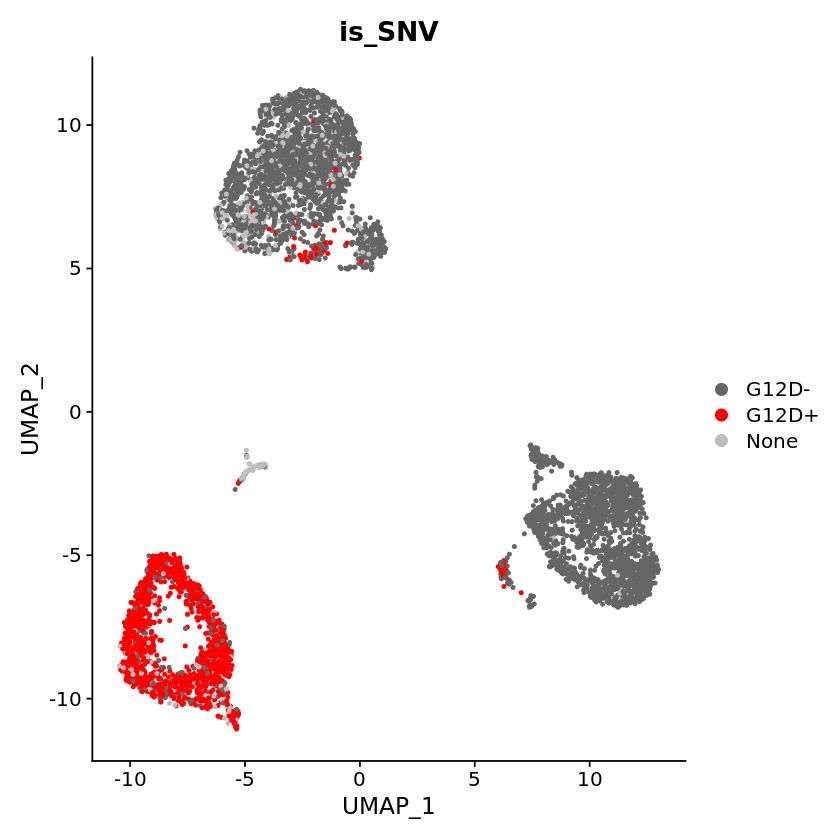

In [49]:
# plot SNV in UMAP
DimPlot(rds, reduction = "umap",group.by = "is_SNV",pt.size = 0.75)+
    scale_color_manual(values = c("gray40", "red", "gray"))

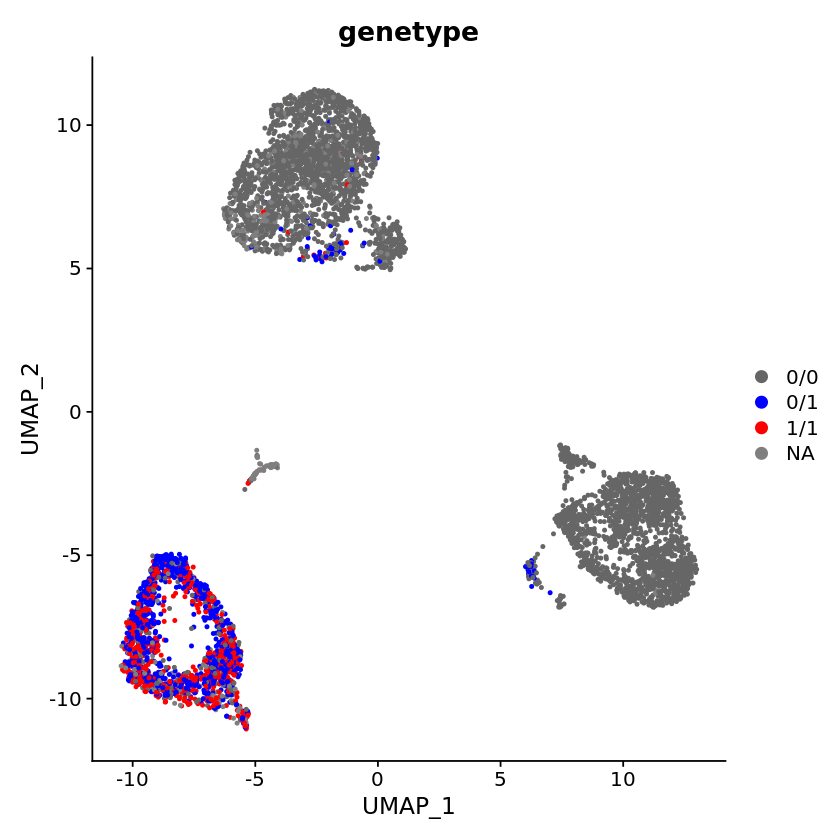

In [50]:
# plot genetype in UMAP
DimPlot(rds, reduction = "umap",group.by = "genetype",pt.size = 0.75)+
    scale_color_manual(values = c("gray40", "blue", "red", "gray"))

In [51]:
# count SNV in each celltype
total.cell <- rds@meta.data %>% group_by(celltype) %>% summarise(total_cell = n())
rds@meta.data %>% 
    group_by(celltype, is_SNV) %>% 
    summarise(ncell = n()) %>% 
    left_join(total.cell, by = "celltype") %>% 
    mutate(percent = round(100 * ncell/total_cell,2)) %>% 
    dplyr::filter(is_SNV != "None")

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.


celltype,is_SNV,ncell,total_cell,percent
<chr>,<glue>,<int>,<int>,<dbl>
type_A,G12D-,251,1772,14.16
type_A,G12D+,1367,1772,77.14
type_B,G12D-,2118,2430,87.16
type_B,G12D+,14,2430,0.58
type_C,G12D-,1798,1812,99.23


In [52]:
# count SNV in each celltype and genetype
total.cell <- rds@meta.data %>% group_by(celltype) %>% summarise(total_cell = n())
rds@meta.data %>% 
    group_by(celltype, is_SNV, genetype) %>% 
    summarise(ncell = n()) %>% 
    left_join(total.cell, by = "celltype") %>% 
    mutate(percent = round(100 * ncell/total_cell,2)) %>% 
    dplyr::filter(is_SNV != "None")

`summarise()` has grouped output by 'celltype', 'is_SNV'. You can override using the `.groups` argument.


celltype,is_SNV,genetype,ncell,total_cell,percent
<chr>,<glue>,<chr>,<int>,<int>,<dbl>
type_A,G12D-,0/0,251,1772,14.16
type_A,G12D+,0/1,829,1772,46.78
type_A,G12D+,1/1,538,1772,30.36
type_B,G12D-,0/0,2118,2430,87.16
type_B,G12D+,0/1,10,2430,0.41
type_B,G12D+,1/1,4,2430,0.16
type_C,G12D-,0/0,1798,1812,99.23


In [63]:
# Find markergenes between G12D+ and G12D- in cell type_A
rds.snp <- subset(rds, is_SNV %in% c(str_glue("{protein.use}+"), str_glue("{protein.use}-")))
rds.snp <- subset(rds.snp, celltype %in% c("type_A"))
Idents(rds.snp) <- rds.snp@meta.data$is_SNV

marker.df <- FindMarkers(rds.snp, ident.1 = str_glue("{protein.use}+"), ident.2 = str_glue("{protein.use}-")) %>% 
    filter(p_val_adj <= 0.05)

marker.gene.test <- head(rownames(marker.df %>% filter(avg_log2FC > 0)), 4)

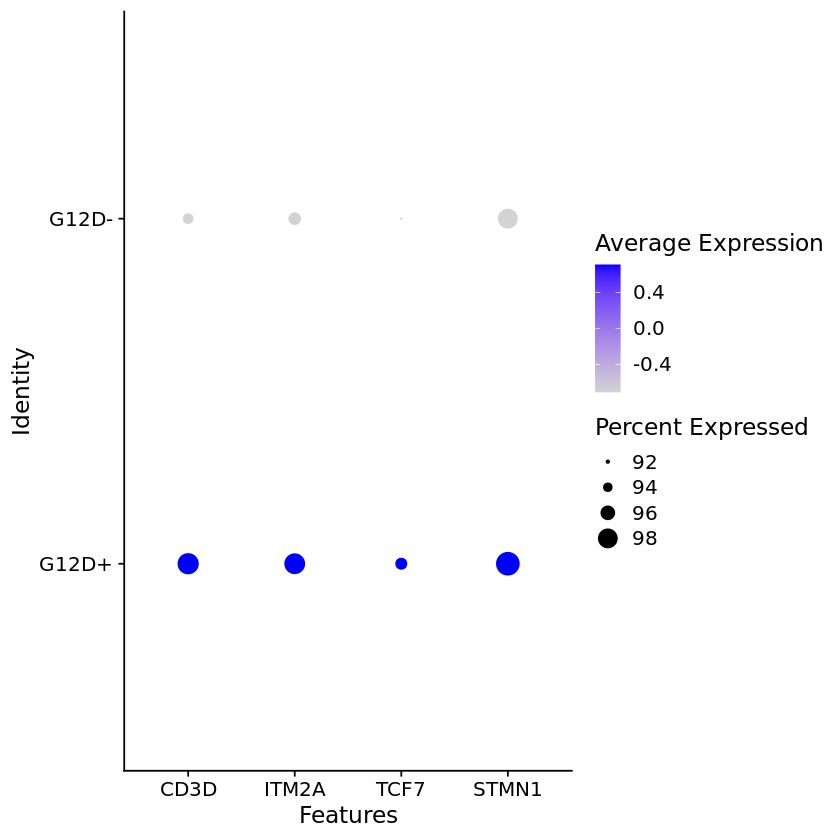

In [64]:
DotPlot(rds.snp,features = marker.gene.test)

In [25]:
# gene symbol to gene id 
gene.ids <- bitr(
    geneID = marker.genes, 
    fromType = "SYMBOL",
    toType=c("ENTREZID","ENSEMBL"), 
    OrgDb="org.Hs.eg.db")
head(gene.ids, 3)

'select()' returned 1:many mapping between keys and columns



,SYMBOL,ENTREZID,ENSEMBL
,<chr>,<chr>,<chr>
1,CCND2,894,ENSG00000118971
2,TESC,54997,ENSG00000088992
3,CTSZ,1522,ENSG00000101160


Reading KEGG annotation online:


Reading KEGG annotation online:


wrong orderBy parameter; set to default `orderBy = "x"`



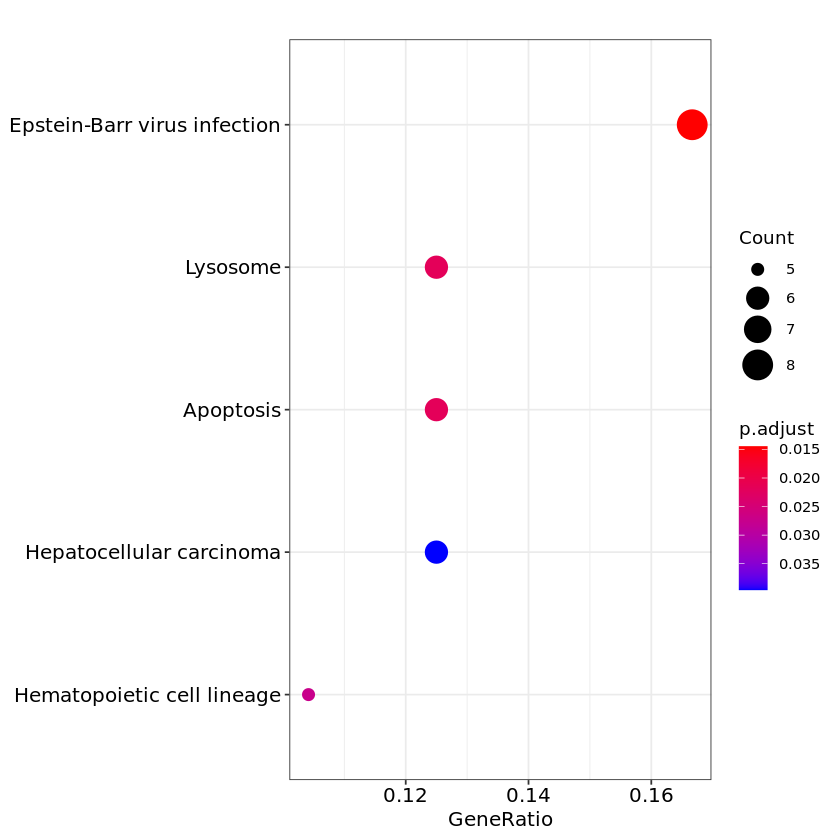

In [26]:
# KEGG analysis
kegg <- enrichKEGG(
    gene = gene.ids$ENTREZID, 
    organism = "hsa", 
    keyType = "kegg", 
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    minGSSize = 10, 
    maxGSSize = 500,
    qvalueCutoff = 0.2,
    use_internal_data = FALSE)
dotplot(kegg)

wrong orderBy parameter; set to default `orderBy = "x"`



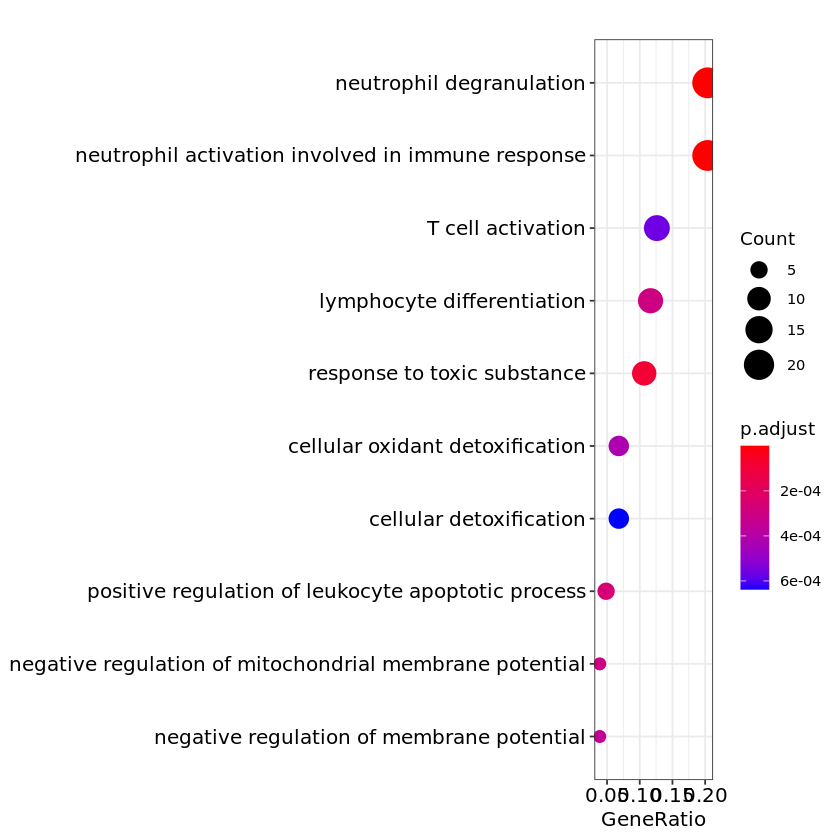

In [27]:
# GO analysis
go <- enrichGO(
    gene.ids$ENTREZID, 
    OrgDb = org.Hs.eg.db, 
    ont='ALL',
    pAdjustMethod = 'BH',
    pvalueCutoff = 0.05, 
    qvalueCutoff = 0.2, 
    keyType = 'ENTREZID')
dotplot(go)

In [28]:
# detail results: kegg
kegg@result %>% head(3)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05169,hsa05169,Epstein-Barr virus infection,8/48,202/6451,0.0001033476,0.01446866,0.01283686,894/6850/4067/915/581/916/917/5701,8
hsa04142,hsa04142,Lysosome,6/48,132/6451,0.0003970166,0.02174495,0.01929251,1522/9516/1512/23312/55353/1075,6
hsa04210,hsa04210,Apoptosis,6/48,136/6451,0.0004659632,0.02174495,0.01929251,1522/1512/7277/581/71/1075,6


In [29]:
# detail results: GO
go@result %>% head(3)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0043312,BP,GO:0043312,neutrophil degranulation,21/103,487/18866,1.673068e-13,2.107704e-10,1.709847e-10,1522/6850/4332/4257/6036/932/566/1512/290/56729/2934/5657/23593/2512/79895/6286/4353/5269/10549/1075/5701,21
GO:0002283,BP,GO:0002283,neutrophil activation involved in immune response,21/103,490/18866,1.884402e-13,2.107704e-10,1.709847e-10,1522/6850/4332/4257/6036/932/566/1512/290/56729/2934/5657/23593/2512/79895/6286/4353/5269/10549/1075/5701,21
GO:0009636,BP,GO:0009636,response to toxic substance,11/103,250/18866,1.210307e-07,9.024852e-05,7.321293e-05,4257/4067/6352/4259/445/581/4353/1728/6415/10549/10935,11


In [30]:
# package version
sessionInfo()

R version 4.0.1 (2020-06-06)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /SGRNJ01/Public/Software/conda_env/cenv_lzh/lib/libopenblasp-r0.3.6.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Hs.eg.db_3.12.0    AnnotationDbi_1.52.0   IRanges_2.24.1        
 [4] S4Vectors_0.28.1       Biobase_2.50.0         BiocGenerics_0.36.0   
 [7] clusterProfiler_3.18.1 SeuratObject_4.0.2     Seurat_4.0.1          
[10] forcats_0.5.1          stringr_1.4.0  